不使用reconstruction loss的卷积条件变分自编码器生成MNIST数据
===

In [1]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

# 1.全局设置

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters
random_seed = 0
learning_rate = 0.001
num_epochs = 50
batch_size = 128

# Architecture
num_classes = 10
num_features = 784
num_latent = 50

Device: cuda:0


# 2.导入数据

In [3]:
train_dataset = datasets.MNIST(root='/input/MNIST/', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='/input/MNIST/', 
                              train=False, 
                              transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# 3.模型

In [4]:
def to_onehot(labels, num_classes, device):

    labels_onehot = torch.zeros(labels.size()[0], num_classes).to(device)
    labels_onehot.scatter_(1, labels.view(-1, 1), 1)

    return labels_onehot

class ConditionalVariationalAutoencoder(torch.nn.Module):

    def __init__(self, num_features, num_latent, num_classes):
        super(ConditionalVariationalAutoencoder, self).__init__()
        
        self.num_classes = num_classes
        
        
        ###############
        # ENCODER
        ##############
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2

        self.enc_conv_1 = torch.nn.Conv2d(in_channels=1+self.num_classes,
                                          out_channels=16,
                                          kernel_size=(6, 6),
                                          stride=(2, 2),
                                          padding=0)

        self.enc_conv_2 = torch.nn.Conv2d(in_channels=16,
                                          out_channels=32,
                                          kernel_size=(4, 4),
                                          stride=(2, 2),
                                          padding=0)                 
        
        self.enc_conv_3 = torch.nn.Conv2d(in_channels=32,
                                          out_channels=64,
                                          kernel_size=(2, 2),
                                          stride=(2, 2),
                                          padding=0)                     
        
        self.z_mean = torch.nn.Linear(64*2*2, num_latent)
        # in the original paper (Kingma & Welling 2015, we use
        # have a z_mean and z_var, but the problem is that
        # the z_var can be negative, which would cause issues
        # in the log later. Hence we assume that latent vector
        # has a z_mean and z_log_var component, and when we need
        # the regular variance or std_dev, we simply use 
        # an exponential function
        self.z_log_var = torch.nn.Linear(64*2*2, num_latent)
        
        
        
        ###############
        # DECODER
        ##############
        
        self.dec_linear_1 = torch.nn.Linear(num_latent+self.num_classes, 64*2*2)
               
        self.dec_deconv_1 = torch.nn.ConvTranspose2d(in_channels=64,
                                                     out_channels=32,
                                                     kernel_size=(2, 2),
                                                     stride=(2, 2),
                                                     padding=0)
                                 
        self.dec_deconv_2 = torch.nn.ConvTranspose2d(in_channels=32,
                                                     out_channels=16,
                                                     kernel_size=(4, 4),
                                                     stride=(3, 3),
                                                     padding=1)
        
        self.dec_deconv_3 = torch.nn.ConvTranspose2d(in_channels=16,
                                                     out_channels=1,
                                                     kernel_size=(6, 6),
                                                     stride=(3, 3),
                                                     padding=4)        


    def reparameterize(self, z_mu, z_log_var):
        # Sample epsilon from standard normal distribution
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(device)
        # note that log(x^2) = 2*log(x); hence divide by 2 to get std_dev
        # i.e., std_dev = exp(log(std_dev^2)/2) = exp(log(var)/2)
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def encoder(self, features, targets):
        
        ### Add condition
        onehot_targets = to_onehot(targets, self.num_classes, device)
        onehot_targets = onehot_targets.view(-1, self.num_classes, 1, 1)
        
        ones = torch.ones(features.size()[0], 
                          self.num_classes,
                          features.size()[2], 
                          features.size()[3], 
                          dtype=features.dtype).to(device)
        ones = ones * onehot_targets
        x = torch.cat((features, ones), dim=1)
        
        x = self.enc_conv_1(x)
        x = F.leaky_relu(x)
        #print('conv1 out:', x.size())
        
        x = self.enc_conv_2(x)
        x = F.leaky_relu(x)
        #print('conv2 out:', x.size())
        
        x = self.enc_conv_3(x)
        x = F.leaky_relu(x)
        #print('conv3 out:', x.size())
        
        z_mean = self.z_mean(x.view(-1, 64*2*2))
        z_log_var = self.z_log_var(x.view(-1, 64*2*2))
        encoded = self.reparameterize(z_mean, z_log_var)
        return z_mean, z_log_var, encoded
    
    def decoder(self, encoded, targets):
        ### Add condition
        onehot_targets = to_onehot(targets, self.num_classes, device)
        encoded = torch.cat((encoded, onehot_targets), dim=1)        
        
        x = self.dec_linear_1(encoded)
        x = x.view(-1, 64, 2, 2)
        
        x = self.dec_deconv_1(x)
        x = F.leaky_relu(x)
        #print('deconv1 out:', x.size())
        
        x = self.dec_deconv_2(x)
        x = F.leaky_relu(x)
        #print('deconv2 out:', x.size())
        
        x = self.dec_deconv_3(x)
        x = F.leaky_relu(x)
        #print('deconv1 out:', x.size())
        
        decoded = torch.sigmoid(x)
        return decoded

    def forward(self, features, targets):
        
        z_mean, z_log_var, encoded = self.encoder(features, targets)
        decoded = self.decoder(encoded, targets)
        
        return z_mean, z_log_var, encoded, decoded

    
torch.manual_seed(random_seed)
model = ConditionalVariationalAutoencoder(num_features,
                                          num_latent,
                                          num_classes)
model = model.to(device)
    

##########################
### COST AND OPTIMIZER
##########################

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

# 4.训练

In [5]:
start_time = time.time()

for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
        targets = targets.to(device)

        ### FORWARD AND BACK PROP
        z_mean, z_log_var, encoded, decoded = model(features, targets)

        # cost = reconstruction loss + Kullback-Leibler divergence
        kl_divergence = (0.5 * (z_mean**2 + 
                                torch.exp(z_log_var) - z_log_var - 1)).sum()
        
        
        ### Add condition
        # Disabled for reconstruction loss as it gives poor results
        """
        onehot_targets = to_onehot(targets, num_classes, device)
        onehot_targets = onehot_targets.view(-1, num_classes, 1, 1)
        
        ones = torch.ones(features.size()[0], 
                          num_classes,
                          features.size()[2], 
                          features.size()[3], 
                          dtype=features.dtype).to(device)
        ones = ones * onehot_targets
        x_con = torch.cat((features, ones), dim=1)
        """
        
        ### Compute loss
        #pixelwise_bce = F.binary_cross_entropy(decoded, x_con, reduction='sum')
        pixelwise_bce = F.binary_cross_entropy(decoded, features, reduction='sum')
        cost = kl_divergence + pixelwise_bce
        
        ### UPDATE MODEL PARAMETERS
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
            
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/050 | Batch 000/469 | Cost: 69516.4531
Epoch: 001/050 | Batch 050/469 | Cost: 65598.3359
Epoch: 001/050 | Batch 100/469 | Cost: 38662.0859
Epoch: 001/050 | Batch 150/469 | Cost: 31640.9805
Epoch: 001/050 | Batch 200/469 | Cost: 29523.8652
Epoch: 001/050 | Batch 250/469 | Cost: 27396.7715
Epoch: 001/050 | Batch 300/469 | Cost: 27141.0273
Epoch: 001/050 | Batch 350/469 | Cost: 25879.5879
Epoch: 001/050 | Batch 400/469 | Cost: 25646.9805
Epoch: 001/050 | Batch 450/469 | Cost: 25497.5527
Time elapsed: 0.93 min
Epoch: 002/050 | Batch 000/469 | Cost: 24966.4336
Epoch: 002/050 | Batch 050/469 | Cost: 24453.9922
Epoch: 002/050 | Batch 100/469 | Cost: 24652.6914
Epoch: 002/050 | Batch 150/469 | Cost: 25062.0586
Epoch: 002/050 | Batch 200/469 | Cost: 24368.4453
Epoch: 002/050 | Batch 250/469 | Cost: 23029.9453
Epoch: 002/050 | Batch 300/469 | Cost: 23433.6328
Epoch: 002/050 | Batch 350/469 | Cost: 22200.3066
Epoch: 002/050 | Batch 400/469 | Cost: 23910.5605
Epoch: 002/050 | Batch 450/

Epoch: 016/050 | Batch 350/469 | Cost: 14333.1543
Epoch: 016/050 | Batch 400/469 | Cost: 14948.8984
Epoch: 016/050 | Batch 450/469 | Cost: 14870.9033
Time elapsed: 15.62 min
Epoch: 017/050 | Batch 000/469 | Cost: 14217.0859
Epoch: 017/050 | Batch 050/469 | Cost: 14190.7910
Epoch: 017/050 | Batch 100/469 | Cost: 14470.7480
Epoch: 017/050 | Batch 150/469 | Cost: 14750.2822
Epoch: 017/050 | Batch 200/469 | Cost: 15135.3887
Epoch: 017/050 | Batch 250/469 | Cost: 15044.7568
Epoch: 017/050 | Batch 300/469 | Cost: 14351.4189
Epoch: 017/050 | Batch 350/469 | Cost: 15205.0645
Epoch: 017/050 | Batch 400/469 | Cost: 14696.6309
Epoch: 017/050 | Batch 450/469 | Cost: 14345.5430
Time elapsed: 16.58 min
Epoch: 018/050 | Batch 000/469 | Cost: 14421.1777
Epoch: 018/050 | Batch 050/469 | Cost: 14286.2607
Epoch: 018/050 | Batch 100/469 | Cost: 14892.2168
Epoch: 018/050 | Batch 150/469 | Cost: 14537.9531
Epoch: 018/050 | Batch 200/469 | Cost: 14393.4561
Epoch: 018/050 | Batch 250/469 | Cost: 14823.4043
Ep

Epoch: 032/050 | Batch 200/469 | Cost: 13810.7090
Epoch: 032/050 | Batch 250/469 | Cost: 13892.9814
Epoch: 032/050 | Batch 300/469 | Cost: 13990.9902
Epoch: 032/050 | Batch 350/469 | Cost: 14168.8633
Epoch: 032/050 | Batch 400/469 | Cost: 13914.3340
Epoch: 032/050 | Batch 450/469 | Cost: 13692.5469
Time elapsed: 31.32 min
Epoch: 033/050 | Batch 000/469 | Cost: 14022.9668
Epoch: 033/050 | Batch 050/469 | Cost: 14164.4590
Epoch: 033/050 | Batch 100/469 | Cost: 14562.3340
Epoch: 033/050 | Batch 150/469 | Cost: 14169.7939
Epoch: 033/050 | Batch 200/469 | Cost: 13814.1621
Epoch: 033/050 | Batch 250/469 | Cost: 14096.2715
Epoch: 033/050 | Batch 300/469 | Cost: 13937.5820
Epoch: 033/050 | Batch 350/469 | Cost: 14702.8096
Epoch: 033/050 | Batch 400/469 | Cost: 14640.0283
Epoch: 033/050 | Batch 450/469 | Cost: 13842.9727
Time elapsed: 32.27 min
Epoch: 034/050 | Batch 000/469 | Cost: 13834.0254
Epoch: 034/050 | Batch 050/469 | Cost: 13794.7900
Epoch: 034/050 | Batch 100/469 | Cost: 14107.8623
Ep

Epoch: 048/050 | Batch 050/469 | Cost: 14262.1621
Epoch: 048/050 | Batch 100/469 | Cost: 13748.3828
Epoch: 048/050 | Batch 150/469 | Cost: 13767.5547
Epoch: 048/050 | Batch 200/469 | Cost: 13666.9727
Epoch: 048/050 | Batch 250/469 | Cost: 13849.0410
Epoch: 048/050 | Batch 300/469 | Cost: 14099.3965
Epoch: 048/050 | Batch 350/469 | Cost: 13873.7246
Epoch: 048/050 | Batch 400/469 | Cost: 13607.0176
Epoch: 048/050 | Batch 450/469 | Cost: 13380.5322
Time elapsed: 47.27 min
Epoch: 049/050 | Batch 000/469 | Cost: 13756.8242
Epoch: 049/050 | Batch 050/469 | Cost: 14295.4873
Epoch: 049/050 | Batch 100/469 | Cost: 13758.7773
Epoch: 049/050 | Batch 150/469 | Cost: 13471.9219
Epoch: 049/050 | Batch 200/469 | Cost: 13911.4395
Epoch: 049/050 | Batch 250/469 | Cost: 13674.9707
Epoch: 049/050 | Batch 300/469 | Cost: 14329.0332
Epoch: 049/050 | Batch 350/469 | Cost: 13455.1074
Epoch: 049/050 | Batch 400/469 | Cost: 12603.2070
Epoch: 049/050 | Batch 450/469 | Cost: 13709.5078
Time elapsed: 48.28 min
Ep

# 5.评估

## 5.1.重构

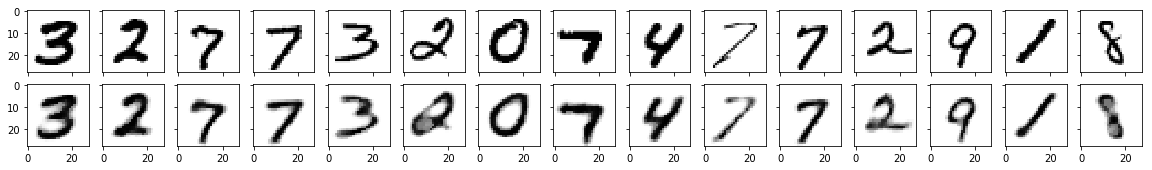

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt


##########################
### VISUALIZATION
##########################

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images, 0]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        cpu_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(cpu_img.view((image_width, image_width)), cmap='binary')

## 5.2.生成

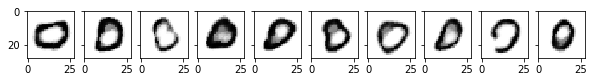

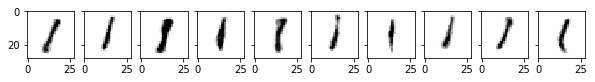

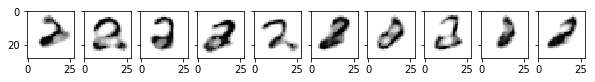

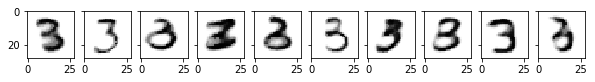

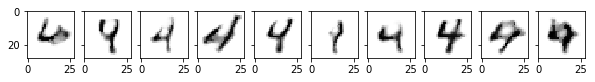

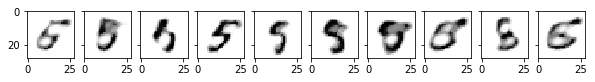

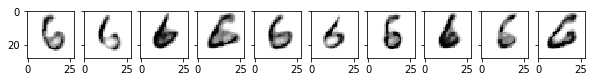

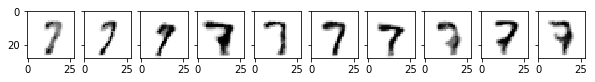

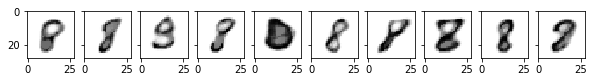

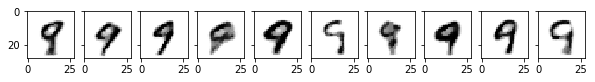

In [8]:
for i in range(10):

    ##########################
    ### RANDOM SAMPLE
    ##########################    
    
    labels = torch.tensor([i]*10).to(device)
    n_images = labels.size()[0]
    rand_features = torch.randn(n_images, num_latent).to(device)
    new_images = model.decoder(rand_features, labels)

    ##########################
    ### VISUALIZATION
    ##########################

    image_width = 28

    fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(10, 2.5), sharey=True)
    decoded_images = new_images[:n_images, 0]

    for ax, img in zip(axes, decoded_images):
        cpu_img = img.detach().to(torch.device('cpu'))
        ax.imshow(cpu_img.view((image_width, image_width)), cmap='binary')